In [ ]:
###############################################

# This file includes code borrowed from: 
# Chambel, Gonçalo. “Generating Realistic Pokemons using a DCGAN.” Medium, 5 Oct 2022, 
# https://medium.com/@goncalorrc/generating-realistic-pokemons-using-a-dcgan-331c7f75e211.

###############################################

# Dataset used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [1]:
#Import libraries
import os,random
from tensorflow.keras import preprocessing
import tensorflow as tf
import numpy as np
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, BatchNormalization, LeakyReLU, ReLU, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras import mixed_precision
import random
from PIL import Image

2023-03-31 13:04:28.472010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !unzip "data.zip" -d "data"

In [5]:
#Make sure GPU is running with tensorflow
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have installed TensorFlow with GPU support.")

Default GPU Device: /device:GPU:0


2023-03-31 13:04:35.156320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 13:04:38.290446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 78962 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2023-03-31 13:04:38.291558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 78962 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-03-31 13:04:38.292546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 78962 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, 

In [6]:
#Display how many GPUs are runing
mirrored_strategy = tf.distribute.MirroredStrategy()
devices = tf.config.experimental.list_physical_devices("GPU")

2023-03-31 13:04:38.353266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78962 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2023-03-31 13:04:38.354095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78962 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-03-31 13:04:38.354914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78962 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-03-31 13:04:38.355779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78962 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [7]:
#Define data path and batch size
DATA_PATH = "data/data/seg_train/seg_train"
batch_size = 32

In [8]:
# #standardize all images to 128x128 for training 
# target_size = (128, 128)
# data_dir = pathlib.Path(DATA_PATH)
# for subdir, dirs, files in os.walk(data_dir):
#     for file in files:
#         # Check if file is an image
#         if file.endswith(".jpg") or file.endswith(".png"):
#             # Load image 
#             image_path = os.path.join(subdir, file)
#             image = Image.open(image_path)

#             # Resize image
#             image = image.resize(target_size)

#             # Save resized image
#             image.save(image_path)

In [9]:
# Normalize the pixel values of the image to be between 0 and 1
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image, label

#Turn dataset into readable data as well as labeling
def get_dataset(folder, image_size, batch_size):
    dataset = preprocessing.image_dataset_from_directory(folder, labels = 'inferred', label_mode='int',  
                                                         image_size=(image_size,image_size), batch_size=batch_size)
    return dataset

image_size = 128
batch_size = 32

dataset = get_dataset(DATA_PATH, image_size, batch_size)
dataset.shuffle(buffer_size=len(dataset))
dataset = dataset.map(normalize)

Found 9246 files belonging to 4 classes.


In [10]:
print(dataset)

<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


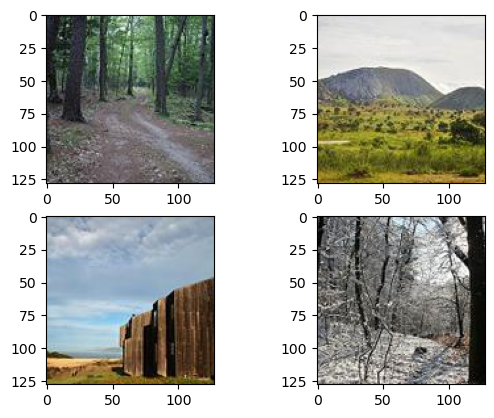

In [16]:
#Display dataset images
for batch in dataset:
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(((batch[0].numpy() + 1) / 2)[i])
    break
plt.show()

In [17]:
def make_generator(latent_dim):
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    generator = Sequential()

    generator.add(Input(shape=(latent_dim,)))
    # 8*8*1024
    generator.add(Dense(8 * 8 * 1024))
    generator.add(Reshape((8, 8, 1024)))

    # 8x8x1024 -> 16x16x512
    generator.add(Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 16x16x512 -> 32x32x256
    generator.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 32x32x256 -> 64x64x128
    generator.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 64x64x128 -> 128x128x64
    generator.add(Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    generator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    generator.add(ReLU())

    # 128x128x64 -> 128x128x3
    generator.add(Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same',
                           kernel_initializer=initializer, use_bias=False, activation='tanh'))

    return generator
    

In [18]:
def make_discriminator():
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    discriminator = Sequential()

    discriminator.add(Input(shape=(128,128,3)))

    # 128*128*3 -> 64*64*64
    discriminator.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 64x64x64 -> 32x32x128
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 32x32x128 -> 16x16x256
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 16x16x256 -> 16x16x512
    discriminator.add(Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    # 16x16x512 -> 8x8x1024
    discriminator.add(Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                             kernel_initializer=initializer, use_bias=False))
    discriminator.add(BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

In [19]:
latent_dim = 100
discriminator = make_discriminator()
generator = make_generator(latent_dim)

/packages/envs/tensorflow-gpu-2.10.0/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [20]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 8, 8, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      6553600   
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)     

In [21]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2400      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51200     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0

2023-03-31 13:04:42.571689: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-31 13:04:42.736308: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-31 13:04:43.989852: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


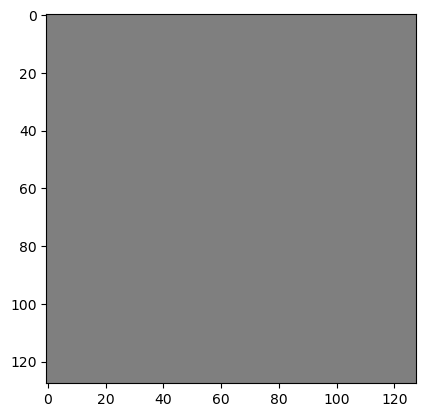

Decision: tf.Tensor([[0.5000002]], shape=(1, 1), dtype=float32)


In [22]:
random_noise = tf.random.normal([1, latent_dim])
generated_image = generator(random_noise, training = False)
plt.imshow((generated_image[0, :, :, :] + 1) / 2)
plt.show()

decision = discriminator(generated_image)
print("Decision:", decision)

In [23]:
#define loss functions
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

def get_optimizer1(lr=0.0004, beta1=0.5):
    return tf.keras.optimizers.Adam(lr, beta1)

def get_optimizer2(lr=0.0002, beta1=0.5):
    return tf.keras.optimizers.Adam(lr, beta1)

#Mirrored scope used for parallel processing
with mirrored_strategy.scope():
    binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()
    generator = make_generator(latent_dim)
    discriminator = make_discriminator()
    gen_optimizer =  get_optimizer1()
    disc_optimizer = get_optimizer2()
    generator.compile(gen_optimizer, loss=binary_cross_entropy)
    discriminator.compile(disc_optimizer, loss=binary_cross_entropy)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [24]:
# Augmentation taken from: https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment-biggan-imagenet/DiffAugment_tf.py
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.2
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = {
    'color': [rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

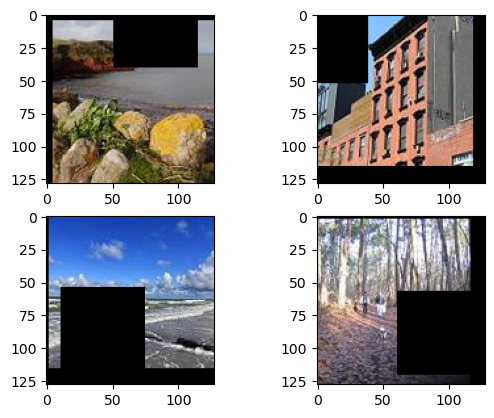

In [25]:
# Visualize images from dataset with diff augmentation
for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow((DiffAugment((batch[0].numpy() + 1) / 2, policy='translation,cutout'))[i])
    break
plt.show()

In [26]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])
    images = DiffAugment(images[0], policy='color,translation,cutout')
    
    with tf.GradientTape() as disc_tape1:
        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output) * 0.9
        disc_loss1 = discriminator_loss(real_targets, real_output)
        
    gradients_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc1, discriminator.trainable_variables))
    
    with tf.GradientTape() as disc_tape2:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')

        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
        
    gradients_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc2, discriminator.trainable_variables))
    
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return disc_loss1 + disc_loss2, gen_loss

In [27]:
def generate_and_save_images(folder, model, epoch, seed, dim=(5, 5), figsize=(5, 5)):
    generated_images = model(seed)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = preprocessing.image.array_to_img((generated_images[i] + 1 / 2))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.savefig(folder + 'generated_image_epoch_%d.png' % epoch)
    plt.close()

In [28]:
seed = tf.random.normal([25, latent_dim])
disc_losses = []
gen_losses = []
generated_images_folder = "gen_images"
trained_models_folder = "trained_models"

def train(dataset, epochs):
    generate_and_save_images(generated_images_folder, generator, 0, seed)
    for epoch in range(epochs):
        disc_loss = gen_loss = 0
        print('Currently training on epoch {} (out of {}).'.format(epoch+1, epochs))
        for image_batch in dataset:
            losses = train_step(image_batch)
            disc_loss += losses[0]
            gen_loss += losses[1]

        generate_and_save_images(generated_images_folder, generator, epoch+1, seed)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())
        print("gen_loss: ", gen_loss.numpy())
        print("disc_loss: ", disc_loss.numpy())

        if epoch % 100 == 0:
            discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epoch)
            generator.save(trained_models_folder + "Generator_epoch_%d" % epoch)

    generate_and_save_images(generated_images_folder, generator, epochs, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epochs)
    generator.save(trained_models_folder + "Generator_epoch_%d" % epochs)

In [ ]:
train(dataset, 500)


Currently training on epoch 1 (out of 500).
gen_loss:  437.9351
disc_loss:  374.91174


INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_0/assets


INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_0/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_0/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_0/assets


Currently training on epoch 2 (out of 500).
gen_loss:  320.34988
disc_loss:  393.86588
Currently training on epoch 3 (out of 500).
gen_loss:  557.5242
disc_loss:  349.60022
Currently training on epoch 4 (out of 500).
gen_loss:  383.5831
disc_loss:  377.3715
Currently training on epoch 5 (out of 500).
gen_loss:  340.60083
disc_loss:  392.24936
Currently training on epoch 6 (out of 500).
gen_loss:  412.11792
disc_loss:  369.6783
Currently training on epoch 7 (out of 500).
gen_loss:  433.9949
disc_loss:  370.9442
Currently training on epoch 8 (out of 500).
gen_loss:  373.74908
disc_loss:  381.5427
Currently training on epoch 9 (out of 500).
gen_loss:  389.94943
disc_loss:  379.77246
Currently training on epoch 10 (out of 500).
gen_loss:  327.92502
disc_loss:  396.06284
Currently training on epoch 11 (out of 500).
gen_loss:  427.27246
disc_loss:  373.45413
Currently training on epoch 12 (out of 500).
gen_loss:  382.82812
disc_loss:  393.7058
Currently training on epoch 13 (out of 500).
gen

INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_100/assets


INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_100/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_100/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_100/assets


Currently training on epoch 102 (out of 500).
gen_loss:  713.34875
disc_loss:  272.15393
Currently training on epoch 103 (out of 500).
gen_loss:  695.5608
disc_loss:  250.87611
Currently training on epoch 104 (out of 500).
gen_loss:  728.44507
disc_loss:  270.66364
Currently training on epoch 105 (out of 500).
gen_loss:  671.8245
disc_loss:  285.43372
Currently training on epoch 106 (out of 500).
gen_loss:  704.0007
disc_loss:  258.2458
Currently training on epoch 107 (out of 500).
gen_loss:  728.80273
disc_loss:  255.83261
Currently training on epoch 108 (out of 500).
gen_loss:  728.7802
disc_loss:  255.2841
Currently training on epoch 109 (out of 500).
gen_loss:  721.53284
disc_loss:  274.40396
Currently training on epoch 110 (out of 500).
gen_loss:  702.9252
disc_loss:  269.9696
Currently training on epoch 111 (out of 500).
gen_loss:  685.4955
disc_loss:  258.3903
Currently training on epoch 112 (out of 500).
gen_loss:  712.2135
disc_loss:  272.34933
Currently training on epoch 113 

INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_200/assets


INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_200/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_200/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_200/assets


Currently training on epoch 202 (out of 500).
gen_loss:  789.7228
disc_loss:  246.48415
Currently training on epoch 203 (out of 500).
gen_loss:  772.4846
disc_loss:  227.01613
Currently training on epoch 204 (out of 500).
gen_loss:  789.34174
disc_loss:  223.8082
Currently training on epoch 205 (out of 500).
gen_loss:  796.20514
disc_loss:  227.47224
Currently training on epoch 206 (out of 500).
gen_loss:  800.1232
disc_loss:  223.08243
Currently training on epoch 207 (out of 500).
gen_loss:  801.64825
disc_loss:  229.7614
Currently training on epoch 208 (out of 500).
gen_loss:  813.6015
disc_loss:  226.60123
Currently training on epoch 209 (out of 500).
gen_loss:  800.8074
disc_loss:  234.18799
Currently training on epoch 210 (out of 500).
gen_loss:  838.1526
disc_loss:  215.16522
Currently training on epoch 211 (out of 500).
gen_loss:  802.4809
disc_loss:  233.00316
Currently training on epoch 212 (out of 500).
gen_loss:  821.9859
disc_loss:  222.99942
Currently training on epoch 213

INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_300/assets


INFO:tensorflow:Assets written to: trained_modelsDiscriminator_epoch_300/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_300/assets


INFO:tensorflow:Assets written to: trained_modelsGenerator_epoch_300/assets


Currently training on epoch 302 (out of 500).
gen_loss:  877.32056
disc_loss:  211.14261
Currently training on epoch 303 (out of 500).
gen_loss:  917.7836
disc_loss:  204.54709
Currently training on epoch 304 (out of 500).
gen_loss:  893.48425
disc_loss:  210.59608
Currently training on epoch 305 (out of 500).
gen_loss:  911.1576
disc_loss:  215.86713
Currently training on epoch 306 (out of 500).
gen_loss:  884.9617
disc_loss:  209.1126
Currently training on epoch 307 (out of 500).
gen_loss:  878.4407
disc_loss:  204.61057
Currently training on epoch 308 (out of 500).
gen_loss:  875.3977
disc_loss:  217.90182
Currently training on epoch 309 (out of 500).
gen_loss:  893.6898
disc_loss:  198.43617
Currently training on epoch 310 (out of 500).
gen_loss:  886.61005
disc_loss:  209.86705
Currently training on epoch 311 (out of 500).
gen_loss:  906.17847
disc_loss:  207.25555
Currently training on epoch 312 (out of 500).
gen_loss:  881.9213
disc_loss:  211.24667
Currently training on epoch 3

In [ ]:
model = tf.keras.models.load_model('trained_modelsGenerator_epoch_500')
noise = tf.random.normal([1,100])


prediction = model.predict([noise])

# Convert prediction to image array
img_array = ((prediction[0] + 1) * 127.5).astype(np.uint8)

# Create PIL image from array
img = Image.fromarray(img_array, 'RGB')

# Save image as JPEG file
img.save('image.jpg')

img = Image.open('image.jpg')
img_arr = np.array(img)

# # Normalize the pixel values to the range [0, 1]
img_arr = img_arr.astype(np.float32) / 255.0

# # Brighten the image by multiplying it with a constant value
brightness = 1
img_arr = img_arr * brightness

# # Clip the pixel values to the range [0, 1]
img_arr = np.clip(img_arr, 0, 1)

# # Convert the pixel values back to the range [0, 255] and convert the image to uint8
img_arr = (img_arr * 255).astype(np.uint8)

# # Create a new PIL Image object from the numpy array
img_out = Image.fromarray(img_arr)

# # Display the output image
img_out.save('output_image.jpg')

